In [245]:
import gymnasium as gym
from gymnasium import spaces

# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
print(device, " in use")
torch.autograd.set_detect_anomaly(True)

# Utility librarues
import base64, io
import random
import pickle
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from itertools import count

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

cuda  in use


/tmp/ipykernel_13324/3926632485.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [246]:
env = gym.make('CartPole-v1')

obs_space = 4
action_space = 2

# Actor Network

In [247]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(obs_space, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_space) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        action_prob = F.softmax(self.out(x), dim=-1)
        return action_prob


# Q Critic Network

In [248]:
class Q_Critic(nn.Module):
    def __init__(self):
        super(Q_Critic, self).__init__()
        self.layer1 = nn.Linear(obs_space + 1, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = self.out(x)
        return Q_val

# Potential ideas

normalise input observation before passing to Q network also action space start point as 1 instead of 0


In [249]:
def give_action(obs, Actor_model): # obs in numpy
    obs = torch.from_numpy(obs).float()
    probs = Actor_model(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action.item(), log_prob


In [250]:
def give_Qsa(obs, action, Qsa_model): # obs, action both in numpy
    #action_arr = 1 + 2*np.eye(action_space)[action].reshape(-1) # [2,1] or [1,2]
    inp = np.concatenate((obs, [action]))
    inp = np.reshape(inp, -1)
    inp = torch.from_numpy(inp).float()
    Qval = Qsa_model(inp)
    return Qval

In [251]:
Actor_model = Actor()
Qsa_model = Q_Critic()
Actor_lr = 0.00001
Actor_optim = optim.SGD(Actor_model.parameters(), lr = Actor_lr)
Qsa_lr = 0.00001
Qsa_optim = optim.SGD(Qsa_model.parameters(), lr = Qsa_lr)

In [252]:
max_itr = 1000
gamma = 0.99
episodes = 500
mini_batch = 4


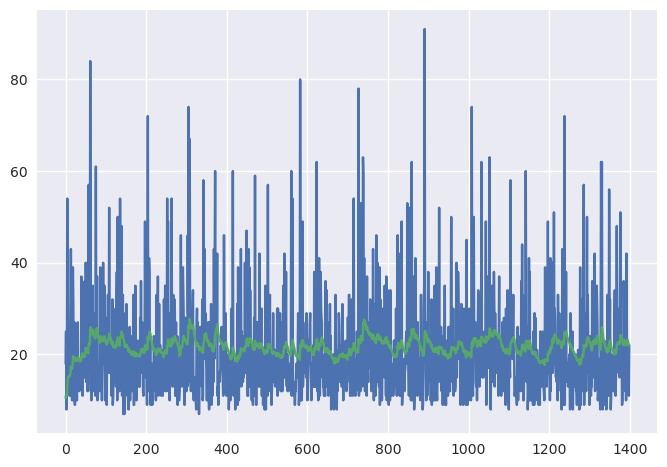

<Figure size 800x550 with 0 Axes>

In [254]:
max_itr_epi = []
avg_reward = []
itr = 0
running_reward = 10

for cnt in count():

    itr += 1
    obs, info = env.reset()
    terminated, truncated = False, False

    ep_reward = 0
    for i in range(max_itr):
        action, log_prob = give_action(obs, Actor_model)
        Qsa = give_Qsa(obs, action, Qsa_model)

        new_obs, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            new_Qsa = 0
        else:
            with torch.no_grad():
                new_action, new_log_prob = give_action(new_obs, Actor_model)
                new_Qsa = give_Qsa(new_obs, new_action, Qsa_model)

        exp = reward + gamma*new_Qsa
        tderr = reward + gamma*new_Qsa - Qsa 

        Qsa_optim.zero_grad()
        Critic_loss_T = (exp - Qsa).pow(2).mean()
        Critic_loss_T.backward(retain_graph=True)
        Qsa_optim.step()

        Actor_optim.zero_grad()
        Actor_loss_T = -log_prob* tderr.detach() #critic_loss(log_prob, tderr.detach())
        Actor_loss_T.backward()
        Actor_optim.step()
    
        obs = new_obs
        ep_reward += reward
        
        if truncated or terminated:
            max_itr_epi.append(i)
            break
    
    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    avg_reward.append(running_reward)

    # if itr % 10 == 0: 
    #     print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
    #         itr, ep_reward, running_reward
    #     ))
    if itr% 100 == 0:
        plt.plot(max_itr_epi)
        plt.plot(avg_reward)
        plt.pause(0.001)

        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Backpropagation
    # Actor_optim.zero_grad()
    # Actor_loss_T = torch.stack(Actor_loss).sum()
    # Actor_loss_T.backward()
    # Actor_optim.step()

    # Qsa_optim.zero_grad()
    # Critic_loss_T = torch.stack(Critic_loss).sum()
    # Critic_loss_T.backward()
    # Qsa_optim.step()

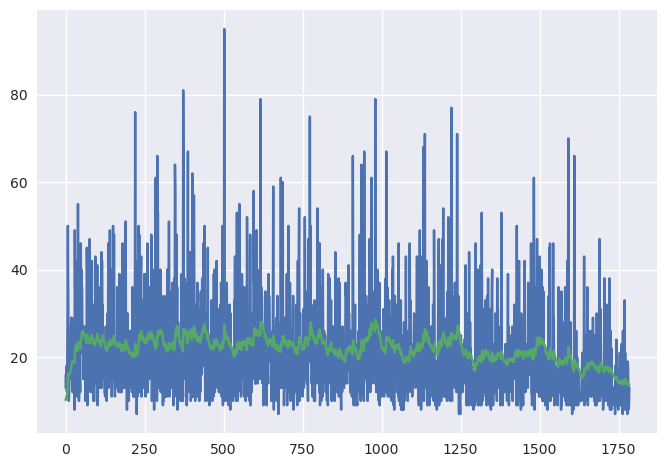

In [244]:
plt.plot(max_itr_epi)
plt.plot(avg_reward)

In [76]:
# There. we finished
# Lets see it in action
done = False
cnt = 0

env = gym.make('CartPole-v1', render_mode="human")

observation, info = env.reset()
while True:
    cnt += 1
    env.render()
    action, log_prob = give_action(observation, Actor_model)
    observation, reward, done, _, _ = env.step(action)
    # Lets see how long it lasts until failing
    if done:
        break
print(f"Game lasted {cnt} moves")

env.close()

Game lasted 27 moves
